# Amazon Copurchased

This is a Python notebook created using "jupyter".

Author: Rafael J. P. dos Santos

## Parameters

We use the parameter below to set the maximum number of edges to be read from the CSV containing edges (links).

In [28]:
max_edges = 10000 # Set quantity to read from file
edges_csv_file = "data/20180812_links"
nodes_csv_file = "data/20180812_nodes"

## Load the libraries

Let's load the Python libraries that we will need throughout the script

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import export_graphviz
import pydot
from sklearn.ensemble import RandomForestRegressor
from __future__ import division
import sklearn
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import hashlib
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.2.


## Read graph

### Read only first lines of datafile

Due to slowness in calculating centrality measures, we use the parameter provided in the beggining of the script to limit the number of edges we will read.

In [30]:
lines = []
total_line_count = 0
with open(edges_csv_file, 'rb') as f:
    f.readline()   # skip first line / header
    while True:
        line = f.readline()
        if not line:
            break
        if not (max_edges > 0 and len(lines) >= max_edges):
            lines.append(line)
        total_line_count += 1
G = nx.parse_edgelist(lines, delimiter=',', nodetype=int)

In [31]:
print "Using %d edges out of %d available (%.2f%% of data)" % (len(lines), total_line_count, len(lines)/total_line_count * 100)

Using 10000 edges out of 229338 available (4.36% of data)


### Calculate nodes centrality measures

Now that we have our NetworkX graph, let's calculate some centrality measures for every node.

In [32]:
centrality_measures = {}

#### Degree

In [33]:
centrality_measures["degree"] = nx.degree(G)

#### Eigenvector centrality

In [34]:
centrality_measures["eigenvector_centrality"] = nx.eigenvector_centrality_numpy(G)

####  Approximate betweenness centrality (current flow)

In [35]:
centrality_measures["betweenness_centrality"] = nx.approximate_current_flow_betweenness_centrality(G)

#### Closeness centrality

In [8]:
# Very slow!
centrality_measures["closeness_centrality"] = nx.closeness_centrality(G)

#### Betweenness centrality

In [9]:
# Very slow!
centrality_measures["betweenness_centrality"] = nx.betweenness_centrality(G)

### Load node properties

Let's load the CSV containing the nodes data (title, price) into a Pandas dataframe, and append the centrality measures calculated above.

In [36]:
df = pd.read_csv(nodes_csv_file)

####  Convert ID to random int to avoid leaking knowledge

In [37]:
sha256_ids = df['id'].map(lambda x: int(hashlib.sha256(str(x)).hexdigest()[0:8], 16))

In [38]:
# Add columns to dataframe
def merge_columns(dataframe, data):
    df = dataframe.copy()
    for col in data:
        rows = []
        for item in data[col].items():
            rows.append({"id": item[0], col: item[1]})
        df = df.merge(pd.DataFrame(rows))
    return df

df = merge_columns(df, centrality_measures)
df = merge_columns(df, {'sha256_id': sha256_ids})

### Let's convert some fields to numeric

In [39]:
categorical_features = [
    'category1',
    'category2',
    'category3',
    'category4',
    'category5',
    'category6',
    'category7',
    'category8',
    'category9',
    'category10',
    'language',
    'coverType',
    'publisher',
    'rankingCategory',
    'authors'
]

numeric_features = [
    'degree',
    'eigenvector_centrality',
    'betweenness_centrality',
    'ranking',
    'reviewCount',
    'pages',
    'weight',
    'height',
    'width',
    'depth',
    'rating'
]

df = df.replace("<<MISSING_DATA>>", np.NaN)
df[numeric_features] = df[numeric_features].apply(pd.to_numeric)
df[['price']] = df[['price']].apply(pd.to_numeric)

for feature in numeric_features:
    df[feature].fillna(df[feature].mean(), inplace = True)

### Remove nodes without price

In [40]:
df = df.drop(df[df["price"].isnull()].index)
#df = df.drop(df[df["price"] > 500].index)

### Inspect columns

In [41]:
df.columns

Index([u'id', u'title', u'url', u'authors', u'coverType', u'publisher',
       u'edition', u'publicationDate', u'rankingCategory', u'category1',
       u'category2', u'category3', u'category4', u'category5', u'category6',
       u'category7', u'category8', u'category9', u'category10', u'isbn10',
       u'isbn13', u'language', u'postProcessed', u'price', u'ranking',
       u'pages', u'reviewCount', u'rating', u'width', u'height', u'depth',
       u'weight', u'eigenvector_centrality', u'degree',
       u'betweenness_centrality', u'sha256_id'],
      dtype='object')

### Features summary

Below we have a summary of the Pandas dataframe. We can see the number of nodes that we are actually analyzing, which depends on the max_edges parameter defined before.

In [42]:
df.describe(include='all')

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality,sha256_id
count,1887.000000,1887,1887,1887,1872,1874,0.0,273,1662,1637,1637,1365,814,461,117,9,0.0,0.0,0.0,1876,1876,1876,1887.0,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1.887000e+03,1887.000000,1887.000000,1.887000e+03
unique,NaN,1840,1887,1466,7,288,NaN,243,1,1,23,112,185,120,42,5,NaN,NaN,NaN,1876,1876,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Macroeconomia,https://www.amazon.com.br/dp/0198769865/,Ian Stewart (Autor),Capa comum,Companhia das Letras,NaN,17 de outubro de 2017,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Faculdade,Probabilidade e Estatística,Abstrata,NaN,NaN,NaN,8521631030,978-8590200215,Português,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5,1,12,1508,98,NaN,3,1662,1637,399,283,136,41,14,3,NaN,NaN,NaN,1,1,1263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1643.043985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,148.906746,58197.556473,412.825546,13.727257,4.481211,15.993920,22.953013,2.305302,467.427140,8.119221e-03,9.182830,0.004266,2.108380e+09
std,1817.245542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,266.318411,74967.622490,269.695568,34.297497,0.496588,2.877004,2.804110,1.213144,209.671432,2.103019e-02,18.597254,0.012793,1.228140e+09
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.900000,7.000000,4.000000,1.000000,1.000000,2.600000,14.000000,0.200000,18.100000,8.902568e-08,1.000000,0.000000,9.916600e+05
25%,509.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,35.900000,11609.000000,232.000000,3.000000,4.484431,14.000000,21.000000,1.400000,340.000000,7.787527e-06,1.000000,0.000000,1.036745e+09
50%,1218.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,56.900000,36009.000000,352.000000,13.782918,4.484431,15.600000,22.900000,2.000000,470.363783,6.130131e-05,2.000000,0.000419,2.092333e+09
75%,1907.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,129.090000,60184.500000,528.000000,13.782918,4.700000,17.200000,24.100000,2.900000,581.000000,2.193281e-03,8.000000,0.003207,3.143779e+09


Below we can inspect the first rows of data, containing title, price, degree and other centrality measures.

In [43]:
df.head(10)

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality,sha256_id
0,1,The Stanford Mathematics Problem Book: With Hi...,https://www.amazon.com.br/dp/0486469247/,"George Polya (Autor),",Capa comum,Dover Publications,NaN,19 de fevereiro de 2009,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Estudo e Ensino,NaN,NaN,NaN,NaN,NaN,0486469247,978-0486469249,Inglês,1,26.25,59183.0,68.0,1.000000,4.000000,14.0,21.0,0.6,181.0,0.014272,19,0.009405,3564330554
1,2,Fourier Series,https://www.amazon.com.br/dp/0486633179/,"Georgi P. Tolstov (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1976,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486633179,978-0486633176,Inglês,1,50.37,56112.0,352.0,3.000000,4.600000,14.6,21.0,1.9,363.0,0.060501,62,0.008992,1309098117
2,3,Probability Theory: A Concise Course,https://www.amazon.com.br/dp/0486635449/,"Y. A. Rozanov (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486635449,978-0486635446,Inglês,1,29.23,44345.0,160.0,13.782918,4.484431,14.4,20.8,0.8,200.0,0.041809,59,0.013582,1260550007
3,4,"Vectors, Tensors and the Basic Equations of Fl...",https://www.amazon.com.br/dp/0486661105/,"Rutherford Aris (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Engenharia e Transporte,Engenharia,Mecânica,Hidráulica,NaN,NaN,NaN,NaN,0486661105,978-0486661100,Inglês,1,48.79,82275.0,320.0,2.000000,4.500000,13.7,21.5,1.6,381.0,0.013503,18,0.009841,4012708477
4,5,Ordinary Differential Equations,https://www.amazon.com.br/dp/0486649407/,"Morris Tenenbaum (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486649407,978-0486649405,Inglês,1,71.63,40840.0,848.0,4.000000,4.500000,13.8,21.8,4.0,939.0,0.084038,88,0.020922,3891707921
5,6,The Variational Principles of Mechanics,https://www.amazon.com.br/dp/0486650677/,"Cornelius Lanczos (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486650677,978-0486650678,Inglês,1,88.15,36960.0,418.0,1.000000,5.000000,13.8,21.5,2.2,581.0,0.051176,43,0.013256,2030201243
6,7,A First Look at Perturbation Theory,https://www.amazon.com.br/dp/0486675513/,James G. Simmonds (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486675513,978-0486675510,Inglês,1,36.10,37291.0,160.0,13.782918,4.484431,13.7,21.5,0.8,159.0,0.010229,9,0.000925,744636978
7,8,Thermodynamics and the Kinetic Theory of Gases...,https://www.amazon.com.br/dp/0486414612/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,18 de outubro de 2010,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Dinâmica,Termodinâmica,NaN,NaN,NaN,NaN,0486414612,978-0486414614,Inglês,1,26.01,24406.0,160.0,2.000000,5.000000,13.8,21.6,1.0,159.0,0.005257,10,0.032203,425205287
8,9,Mechanics,https://www.amazon.com.br/dp/0486607542/,"Jacob P. Den Hartog (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1961,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486607542,978-0486607542,Inglês,1,50.96,90609.0,480.0,13.782918,4.484431,13.6,20.3,2.3,522.0,0.022270,23,0.001865,1246026773
9,10,Statistical Thermodynamics,https://www.amazon.com.br/dp/0486661016/,"Erwin Schrodinger (Autor),",Capa comum,Dover Publications,NaN,NaN,Liv

## Random forest using various features, price as target

### Preparing data

In [44]:
df_with_dummies = pd.get_dummies(df[['sha256_id'] + numeric_features + categorical_features + ['price']],columns=categorical_features,drop_first=True)

In [45]:
feature_list = list(df_with_dummies.drop(columns = ['price']))

features_values = np.array(df_with_dummies.drop(columns = ['price']))
target_value = np.array(df_with_dummies['price'])

features_and_target = np.concatenate((features_values, target_value.reshape(len(target_value), 1)), axis = 1)

#print features_and_target.shape

# Shuffle features_and_target
np.random.shuffle(features_and_target)

limit = int(round(len(target_value) * 0.8))
print "Test percentage", (len(target_value)-limit)/len(target_value)

features = features_and_target[:limit, :-1]
target = features_and_target[:limit, -1]

test_features = features_and_target[limit:, :-1]
test_target = features_and_target[limit: , -1]

print "Train features shape", features.shape
print "Train target shape", target.shape
print "Test features shape", test_features.shape
print "Test target shape", test_target.shape

Test percentage 0.199788023317
Train features shape (1510, 2253)
Train target shape (1510,)
Test features shape (377, 2253)
Test target shape (377,)


### Average price as baseline

It's important to have a baseline, so we can validate our predictions after running our model. One easy choice for baseline is the average price of a book.

We have an average price around R\$43, so this means that a very easy prediction would be to always guess R$43 for the price of any book.

In [46]:
average_target = np.average(target)
print "Average price: R$", average_target

Average price: R$ 153.822059602649


### Cross val score

In [47]:
def baseline_score_function (y_true, y_pred):
    errors_baseline = abs(average_target - y_true)
    return np.mean(errors_baseline)

rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)

scorer = make_scorer(baseline_score_function)

scores = cross_validate(estimator=rf, X=features, y=target, cv=10,
                        scoring = {'abs': 'neg_mean_absolute_error', 'baseline': scorer},
                        return_train_score=False, return_estimator = True)

#print "Abs: ", scores['test_abs']
print "RF abs mean: ", np.mean(np.abs(scores['test_abs']))
print "RF abs std: ", np.std(scores['test_abs'])

#print "Baseline: ", scores['test_baseline']
print "Baseline mean: ", np.mean(scores['test_baseline'])
print "Baseline std: ", np.std(scores['test_baseline'])

# Use best estimator to do some visual reports
rf = scores['estimator'][0]

RF abs mean:  62.9315944370861
RF abs std:  10.372407904091702
Baseline mean:  152.4973747993509
Baseline std:  13.51860314875608


####  List of most important features

In [48]:
importance = zip(feature_list, rf.feature_importances_)
importance.sort(key=lambda x:-x[1])
pd.DataFrame(importance).head(200)

,0,1
0,coverType_Capa dura,0.207951
1,eigenvector_centrality,0.182518
2,pages,0.119881
3,publisher_McGraw-Hill Science/Engineering/Math,0.054673
4,degree,0.044745
5,width,0.044339
6,betweenness_centrality,0.036906
7,category2_Inglês e Outras Línguas,0.035423
8,ranking,0.030167
9,height,0.027858


## Test dataset and visual inspection

In [49]:
test_predictions = rf.predict(test_features)

###  Preço previsto vs. Preço real

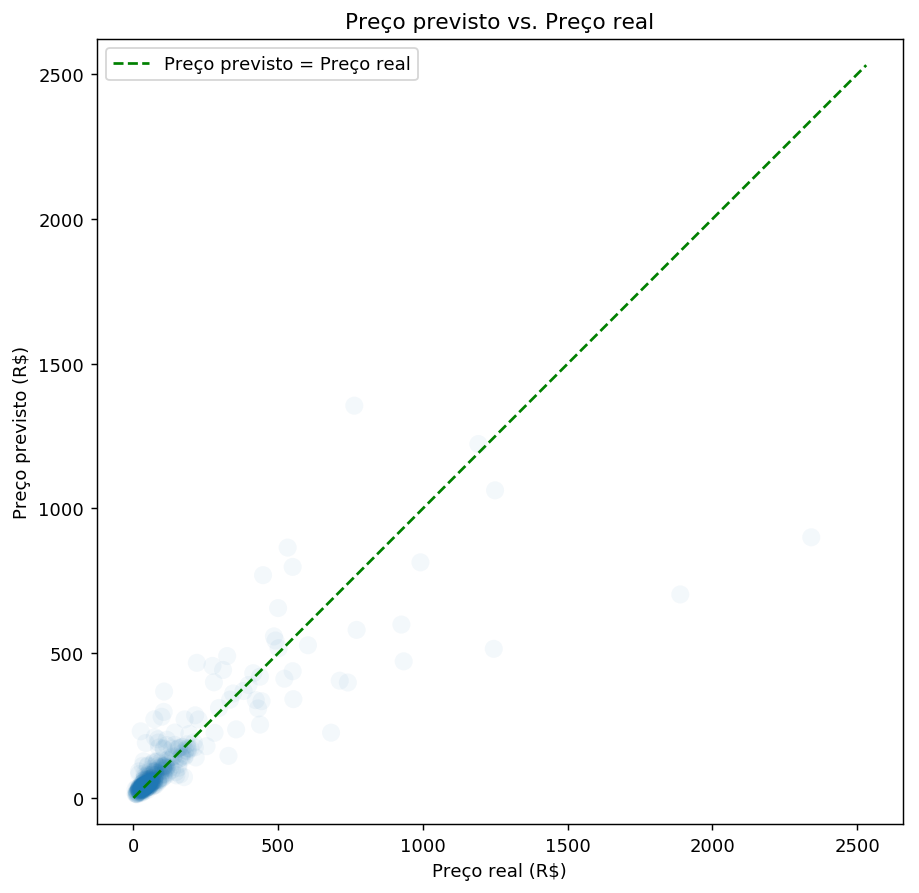

In [50]:
plt.figure(figsize=(8,8), dpi=130)
plt.scatter(test_target, test_predictions, 100, alpha=0.05, edgecolors="none")
baseline = [0, np.max(target)]
plt.plot(baseline, baseline, "--", color="green", label = u"Preço previsto = Preço real")
ax = plt.gca()
ax.set_ylabel(u"Preço previsto (R$)")
ax.set_xlabel(u"Preço real (R$)")
ax.legend()
plt.title(u"Preço previsto vs. Preço real")
plt.axes().set_aspect('equal', 'datalim')
#plt.xlim(0, 250)
#plt.ylim(0, 250)
plt.show()

### Mean absolute error

Now we can compare the errors obtained by our predictions against the errors provided by the baseline (average price). Our prediction errors should be less than the baseline errors to consider the model successful.

In [51]:
# Calculate the absolute errors
errors = abs(test_predictions - test_target)
errors_baseline = abs(average_target - test_target)
# Print out the mean absolute error (mae)
print('Mean absolute prediction error: R$', round(np.mean(errors), 2))
print('Std prediction error: R$', round(np.std(errors), 2))
print('Mean absolute error using average: R$', round(np.mean(errors_baseline), 2))
print('Std prediction error using average: R$', round(np.std(errors_baseline), 2))

('Mean absolute prediction error: R$', 44.23)
('Std prediction error: R$', 122.02)
('Mean absolute error using average: R$', 136.37)
('Std prediction error using average: R$', 189.48)


### Worst predictions

Below we can inspect the rows with the biggest prediction error.

In [52]:
pd.set_option('display.max_columns', None)
data = {
    "all_features": test_features.tolist(),
    "sha256_id": test_features[:, 0],
    "target": test_target,
    "prediction": test_predictions,
    "error": errors,
    "errors_baseline": errors_baseline
}
predicted_df = pd.DataFrame(data = data)
joined_predicted_df = predicted_df
joined_predicted_df = predicted_df.set_index("sha256_id").join(df.set_index("sha256_id"))
joined_predicted_df.sort_values('error', ascending = False).head(20)

,all_features,error,errors_baseline,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.731114e+09,"[1731113829.0, 13.0, 0.0296845571371, 0.004248...",1440.9822,2187.37794,900.2178,2341.20,1779,Modern Physics for Scientists and Engineers,https://www.amazon.com.br/dp/1133103723/,"Stephen T. Thornton (Autor),",Capa dura,Cengage Learning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1133103723,978-1133103721,Inglês,1,2341.20,59185.844728,688.000000,13.782918,4.484431,20.300000,25.400000,3.20000,470.363783,0.029685,13,0.004248
9.158984e+07,"[91589843.0, 12.0, 0.0220459396529, 0.00217781...",1185.9544,1734.93794,702.8056,1888.76,1712,Vector Calculus,https://www.amazon.com.br/dp/1429215089/,"Jerrold E. Marsden (Autor),",Capa dura,W.H. Freeman & Company,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Análise Vetorial,NaN,NaN,NaN,NaN,1429215089,978-1429215084,Inglês,1,1888.76,311760.000000,545.000000,13.782918,4.484431,21.000000,26.000000,3.20000,470.363783,0.022046,12,0.002178
5.445666e+08,"[544566571.0, 3.0, 0.0064072790452, 0.00010142...",729.5040,1090.60794,514.9260,1244.43,2072,"The Physics Companion, 2nd Edition",https://www.amazon.com.br/dp/1138429597/,Anthony C. Fischer-Cripps (Autor),NaN,CRC Press,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1138429597,978-1138429598,Inglês,1,1244.43,59185.844728,420.386983,13.782918,4.484431,16.101266,23.044557,2.33357,470.363783,0.006407,3,0.000101
3.928054e+09,"[3928053536.0, 1.0, 0.0045644804867, 0.0, 5918...",592.2138,608.87794,1354.9138,762.70,2198,Principles of Inorganic Chemistry,https://www.amazon.com.br/dp/1118859103/,Brian W. Pfennig (Autor),Capa dura,Wiley-Blackwell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1118859103,978-1118859100,Inglês,1,762.70,59185.844728,760.000000,13.782918,4.484431,22.400000,28.700000,3.30000,470.363783,0.004564,1,0.000000
3.835611e+09,"[3835611206.0, 6.0, 0.0180205275138, 0.0005097...",461.6150,779.48794,471.6950,933.31,1774,Electronics with Discrete Components,https://www.amazon.com.br/dp/0470889683/,Enrique J. Galvez (Autor),Capa dura,John Wiley & Sons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0470889683,978-0470889688,Inglês,1,933.31,59185.844728,334.000000,13.782918,4.484431,19.500000,23.500000,1.80000,658.000000,0.018021,6,0.000510
1.654200e+08,"[165419954.0, 1.0, 0.00024566011885, 0.0, 7952...",457.1878,528.64794,225.2822,682.47,2174,Strategic Applications of Named Reactions in O...,https://www.amazon.com.br/dp/0124297854/,"Laszlo Kurti (Autor),",Capa comum,Academic Press,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Química,Orgânica,NaN,NaN,NaN,NaN,NaN,0124297854,978-0124297852,Inglês,1,682.47,79528.000000,758.000000,13.782918,4.484431,21.600000,26.700000,3.20000,470.363783,0.000246,1,0.000000
3.359170e+09,"[3359170387.0, 9.0, 0.0142823999243, 0.0112455...",341.7874,586.61794,398.6526,740.44,2153,Computer Simulation of Liquids: Second Edition,https://www.amazon.com.br/dp/0198803192/,"Michael P. Allen (Autor),",Capa dura,OUP Oxford,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Dinâmica,Dinâmica dos Fluidos,NaN,NaN,NaN,NaN,0198803192,978-0198803195,Inglês,1,740.44,312312.000000,640.000000,13.782918,4.484431,17.500000,24.400000,3.60000,470.363783,0.014282,9,0.011246
2.018568e+09,"[2018568255.0, 2.0, 0.00218490372256, 0.000138...",332.1280,378.70794,864.6580,532.53,2007,"Numerical Methods: Design, Analysis, and Compu...",https://www.amazon.com.br/dp/0691151229/,"Anne Greenbaum (Autor),",Capa dura,Princeton University Press,NaN,1 de abril de 2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Best predictions

In [53]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

,all_features,error,errors_baseline,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.389373e+09,"[3389373483.0, 2.0, 5.23349817377e-06, 0.00277...",0.1164,31.16794,185.1064,184.99,1618,Química na Abordagem do Cotidiano - Volume Único,https://www.amazon.com.br/dp/8502630598/,Tito Miragaia Peruzzo (Autor),Capa comum,Saraiva Didático,NaN,NaN,Livros,Livros,Ciências,Química,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8502630598,978-8502630598,Português,1,184.99,48662.0,912.0,13.782918,4.484431,21.2,28.6,5.4,470.363783,0.000005,2,0.002772
2.759353e+09,"[2759353381.0, 1.0, 5.23207748418e-05, 0.0, 63...",0.1640,117.82206,35.8360,36.00,1409,"A Invenção Republicana. Campos Sales, as Bases...",https://www.amazon.com.br/dp/8574752509/,Renato Lessa (Autor),Capa comum,Topbooks,NaN,NaN,Livros,Livros,História,Américas,América Latina,Brasil,NaN,NaN,NaN,NaN,NaN,8574752509,978-8574752501,Português,1,36.00,632.0,335.0,13.782918,4.484431,15.4,23.0,2.0,458.000000,0.000052,1,0.000000
1.397016e+09,"[1397015569.0, 4.0, 0.000390774375878, 0.01082...",0.1712,118.77206,35.2212,35.05,499,A Vida Secreta da Mente,https://www.amazon.com.br/dp/8547000437/,Mariano Sigman (Autor),Capa comum,Objetiva,NaN,NaN,Livros,Livros,Autoajuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8547000437,978-8547000431,Português,1,35.05,6092.0,288.0,1.000000,4.000000,13.4,20.8,2.2,358.000000,0.000391,4,0.010821
1.829069e+09,"[1829069338.0, 2.0, 4.8007818621e-05, 0.000717...",0.1976,122.61206,31.0124,31.21,440,O Tempo Que O Tempo Tem,https://www.amazon.com.br/dp/8537800562/,"Alexandre Cherman (Autor),",Capa comum,Zahar,NaN,NaN,Livros,Livros,Ciências,Física,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8537800562,978-8537800560,Português,1,31.21,58367.0,144.0,9.000000,4.200000,13.2,20.8,1.0,200.000000,0.000048,2,0.000717
1.207356e+09,"[1207355588.0, 2.0, 0.00176012827993, 9.858728...",0.2152,116.35206,37.6852,37.47,1468,Anthropocene: A Very Short Introduction,https://www.amazon.com.br/dp/0198792980/,Erle C. Ellis (Autor),Capa comum,OUP Oxford,NaN,22 de março de 2018,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Ciência da Terra,Ciências Ambientais em Ciência da Terra,NaN,NaN,NaN,NaN,NaN,0198792980,978-0198792987,Inglês,1,37.47,8116.0,208.0,13.782918,4.484431,10.9,17.3,1.5,159.000000,0.001760,2,0.000099
3.083290e+09,"[3083290382.0, 3.0, 0.000226418818443, 0.00064...",0.2244,125.42206,28.1756,28.40,399,Frequência Vibracional,https://www.amazon.com.br/dp/8531611318/,Penney Peirce (Autor),Capa comum,Cultrix,NaN,NaN,Livros,Livros,Autoajuda,Transformação Pessoal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8531611318,978-8531611315,Português,1,28.40,2240.0,296.0,7.000000,4.300000,16.0,22.8,1.6,399.000000,0.000226,3,0.000641
3.633069e+09,"[3633068510.0, 1.0, 2.98367010706e-06, 0.0, 20...",0.2956,98.42206,55.6956,55.40,1065,Sobre A Revolução,https://www.amazon.com.br/dp/8535918469/,Hannah Arendt (Autor),Capa comum,Companhia das Letras,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8535918469,978-8535918465,Português,1,55.40,20132.0,416.0,1.000000,5.000000,13.8,20.8,2.4,499.000000,0.000003,1,0.000000
3.662394e+09,"[3662394008.0, 1.0, 5.23207748418e-05, 0.0, 18...",0.2994,90.92206,63.1994,62.90,1413,Dos ProtoAustríacos a Menger. Uma Breve Histór...,https://www.amazon.com.br/dp/8593751172/,"Ubiratan Jorge Iorio (Autor),",Capa comum,LVM,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Governo e Política,Relações Públicas e Política,Política Econômica,NaN,NaN,NaN,NaN,NaN,8593751172,978-8593751172,Português,1,62.90,18931.0,576.0,1.000000,5.000000,15.6,22.8,3.6,880.000000,0.000052,1,0.000000
2.906005e+09,"[2906004751.0, 1.0, 3.059927

In [54]:
predicted_df.describe()

,error,errors_baseline,prediction,sha256_id,target
count,377.000000,377.000000,377.000000,3.770000e+02,377.000000
mean,44.233867,136.368976,124.199089,2.173902e+09,129.219416
std,122.184347,189.728568,175.528223,1.279203e+09,232.456418
min,0.116400,0.987940,12.372000,1.612626e+07,6.990000
25%,5.084800,78.802060,37.950200,1.008020e+09,34.990000
50%,11.302200,109.632060,58.901800,2.290222e+09,55.490000
75%,27.849200,127.062060,124.854200,3.296395e+09,109.900000
max,1440.982200,2187.377940,1354.913800,4.292174e+09,2341.200000


### Visualize decision tree

In [27]:
# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot',
                feature_names = feature_list, rounded = True)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

<img src="files/image.png">